In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sceneries/data/CameraMask/010841.png
/kaggle/input/sceneries/data/CameraMask/018431.png
/kaggle/input/sceneries/data/CameraMask/007355.png
/kaggle/input/sceneries/data/CameraMask/002712.png
/kaggle/input/sceneries/data/CameraMask/002312.png
/kaggle/input/sceneries/data/CameraMask/018421.png
/kaggle/input/sceneries/data/CameraMask/011054.png
/kaggle/input/sceneries/data/CameraMask/002735.png
/kaggle/input/sceneries/data/CameraMask/017731.png
/kaggle/input/sceneries/data/CameraMask/049288.png
/kaggle/input/sceneries/data/CameraMask/010861.png
/kaggle/input/sceneries/data/CameraMask/022240.png
/kaggle/input/sceneries/data/CameraMask/015020.png
/kaggle/input/sceneries/data/CameraMask/014385.png
/kaggle/input/sceneries/data/CameraMask/022247.png
/kaggle/input/sceneries/data/CameraMask/011480.png
/kaggle/input/sceneries/data/CameraMask/008818.png
/kaggle/input/sceneries/data/CameraMask/006884.png
/kaggle/input/sceneries/data/CameraMask/011772.png
/kaggle/input/sceneries/data/Ca

In [2]:
import os
import torch
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" 
device = torch.device(device)
print(device)

cuda:0


In [4]:
path = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')  
train_list = os.listdir(train_path)
val_list=os.listdir(val_path)
print(len(train_list),len(val_list))

2975 500


/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/1269.jpg


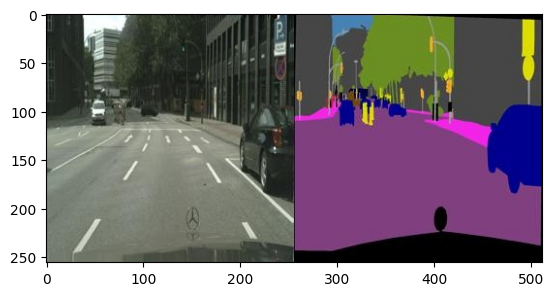

In [5]:
sample_image_path = os.path.join(train_path, train_list[0])
sample_image = Image.open(sample_image_path)
plt.imshow(sample_image)
print(sample_image_path)

In [6]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

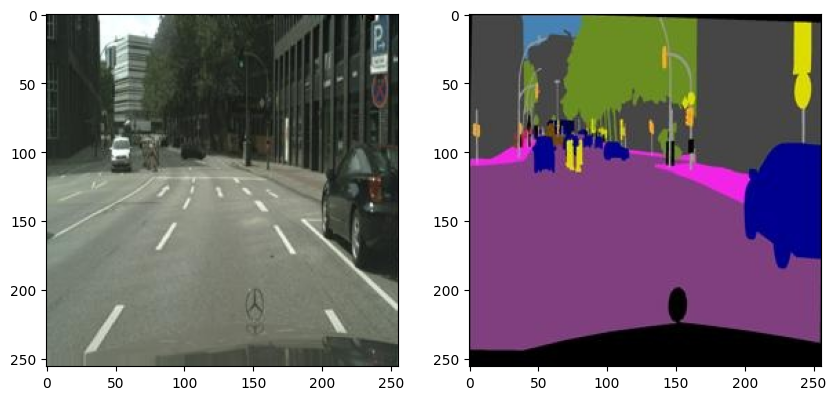

In [7]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

In [8]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [9]:
from sklearn.cluster import KMeans
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

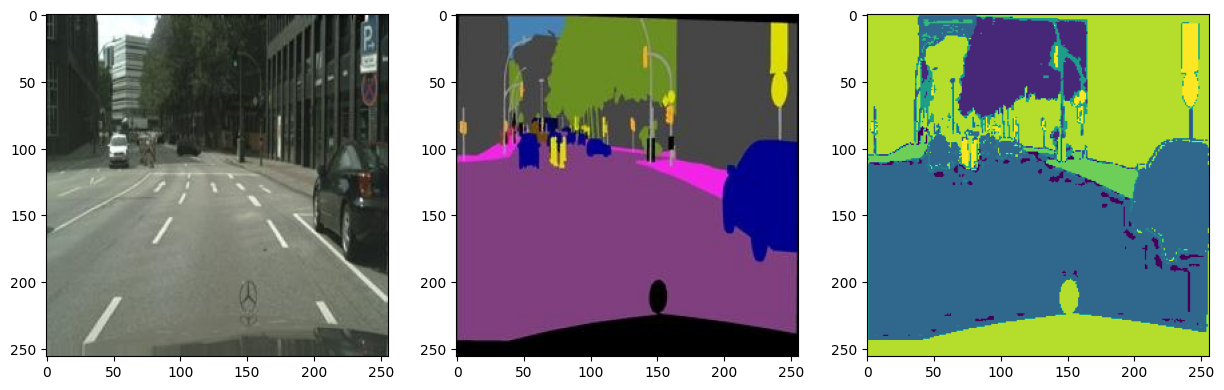

In [10]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [11]:
np. unique(label_class)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [12]:

class CustomDataset(Dataset):
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_list = os.listdir(image_dir)
        self.label_model = label_model
        

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_fn = self.image_list[idx]
        image_path = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_path).convert("RGB")
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
        label_class = torch.Tensor(label_class).long()
        cityscape = self.transform(cityscape)
        return cityscape, label_class

        # Load the image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        


        return cityscape, label
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
        ])

        return transform_ops(image)


In [13]:
train_dataset = CustomDataset(train_path,label_model)

In [14]:
cityscape, label_class = train_dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


In [15]:
import torch.nn as nn
import torch.nn.functional as F
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,3,1,1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
        
        nn.Conv2d(out_channels,out_channels,3,1,1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
        )
    def forward(self,x):
        return self.conv(x)

In [16]:



class UNET(nn.Module):
    def __init__(
        self, in_channels, out_channels, features=[64, 128, 256, 512]
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # reverses the order of skip connections

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            # Exception case --warning--
            if x.shape != skip_connection.shape:
                 x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=False)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return torch.sigmoid(self.final_conv(x))

In [17]:
model = UNET(in_channels=3,out_channels=10)
model = model.to(device)

In [18]:
data_loader = DataLoader(train_dataset, batch_size = 4)
print(len(train_dataset), len(data_loader))
data_iter = iter(data_loader)
X, Y = next(data_iter)

2975 744


In [19]:
X = X.to(device)
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


In [20]:
train_dataset = CustomDataset(train_path,label_model)
train_dataloader = DataLoader(train_dataset, batch_size = 4)

In [21]:

# Move model to the same device as data
model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Number of training epochs
num_epochs = 5

# Training loop
for epoch in tqdm(range(num_epochs)):

    running_loss = 0.0

    for inputs, targets in tqdm(train_dataloader, total=len(train_dataloader), leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
#         optimizer.zero_grad()
        running_loss += loss.item()

    # Print the average training loss for the epoch
    average_loss = running_loss / len(train_dataloader)
    print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/744 [00:00<?, ?it/s]

Training Epoch [1/5], Loss: 1.7369


  0%|          | 0/744 [00:00<?, ?it/s]

Training Epoch [2/5], Loss: 1.6783


  0%|          | 0/744 [00:00<?, ?it/s]

Training Epoch [3/5], Loss: 1.6549


  0%|          | 0/744 [00:00<?, ?it/s]

Training Epoch [4/5], Loss: 1.6387


  0%|          | 0/744 [00:00<?, ?it/s]

Training Epoch [5/5], Loss: 1.6290


In [22]:
model.eval()

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inp

In [23]:
model_name = "U-NET.pth"
torch.save(model.state_dict(), model_name)

In [24]:
model_path = "/kaggle/working/U-NET.pth"
model_ = UNET(in_channels=3,out_channels=10).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [25]:
val_batch_size = 10
val_dataset = CustomDataset(val_path, label_model)
data_loader = DataLoader(val_dataset, batch_size=val_batch_size)

In [26]:
data_iter = iter(data_loader)
X, Y = next(data_iter)
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [27]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

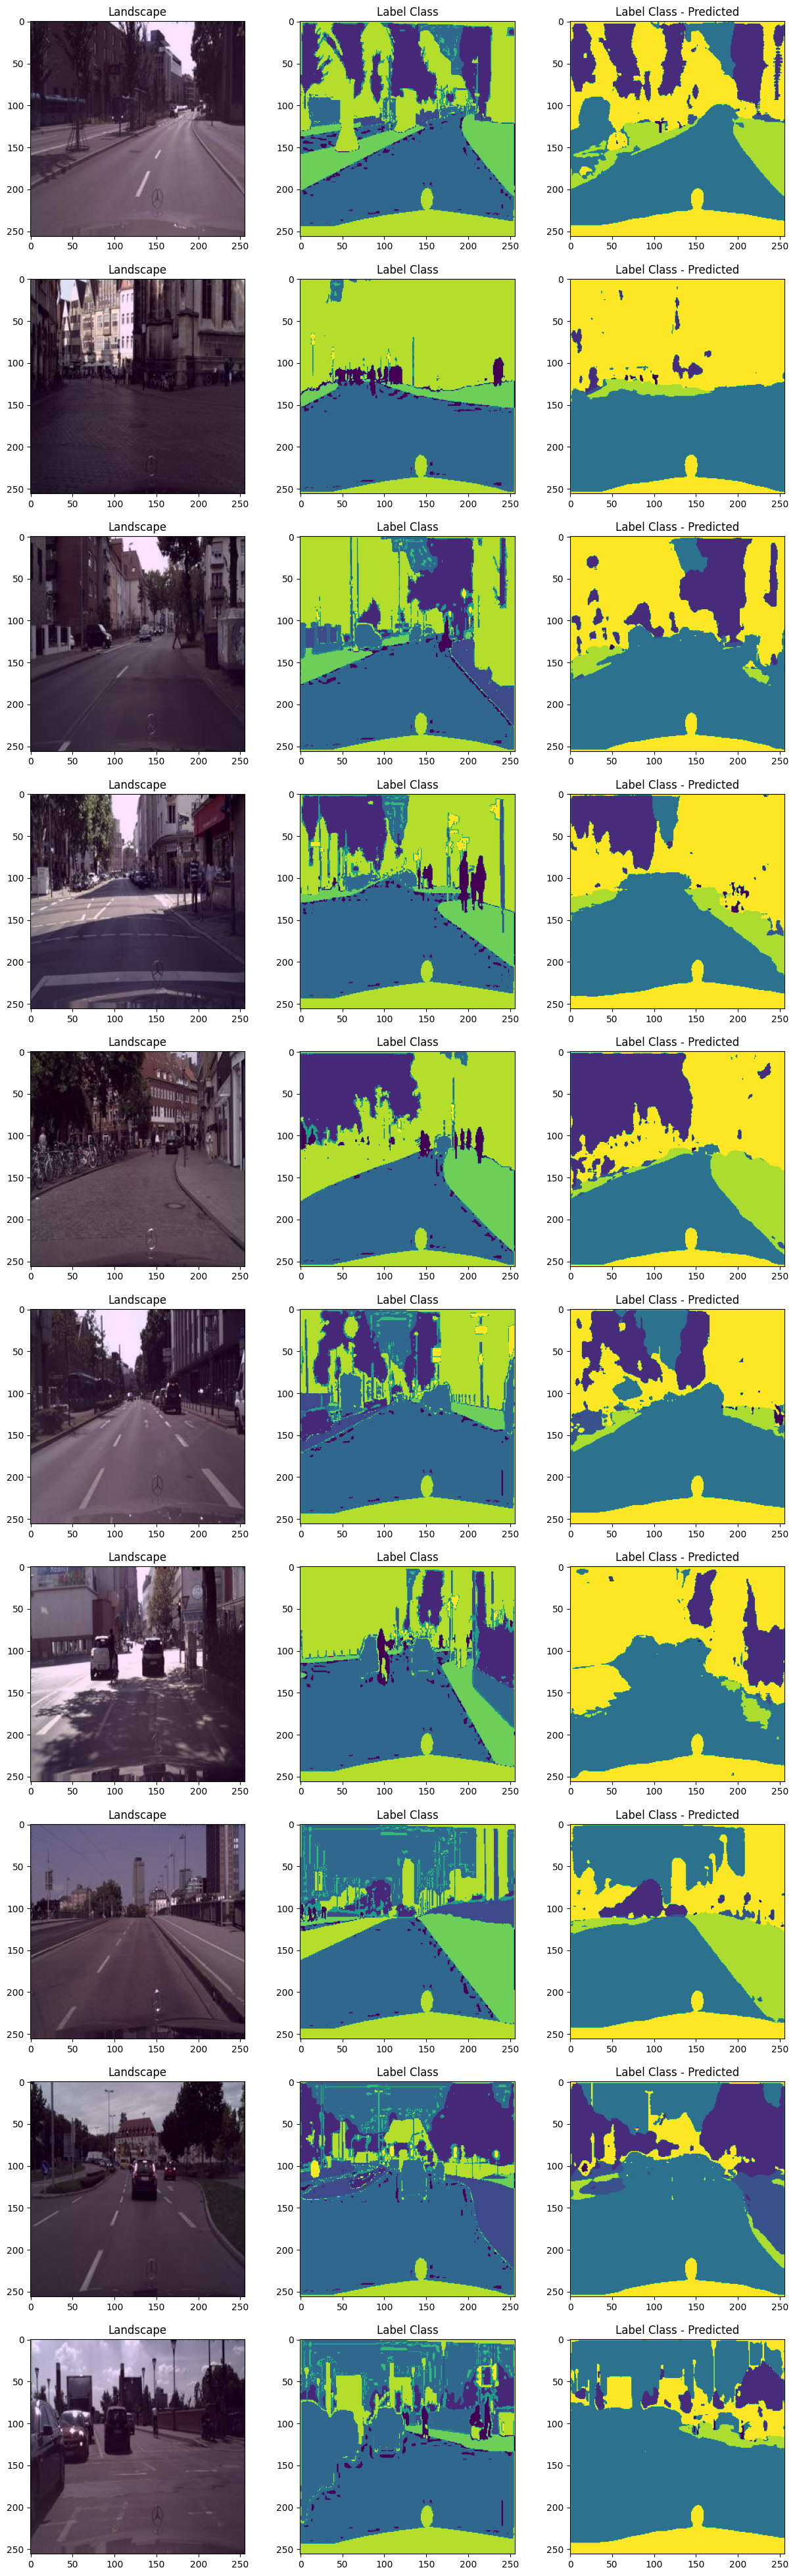

In [28]:
fig, axes = plt.subplots(val_batch_size, 3, figsize=(3*5, val_batch_size*5))

iou_scores = []

for i in range(val_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")